In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder,MinMaxScaler
from sklearn.compose import ColumnTransformer

In [2]:
from google.colab import files

# Upload file(s)
uploaded = files.upload()

# If you uploaded a single file, you can access it like this:
for filename in uploaded.keys():
    print(f"User uploaded file: {filename}")


KeyboardInterrupt: 

In [3]:
df=pd.read_csv('/content/Crop_production.csv')
df

,Unnamed: 0,State_Name,Crop_Type,Crop,N,P,K,pH,rainfall,temperature,Area_in_hectares,Production_in_tons,Yield_ton_per_hec
0,0,andhra pradesh,kharif,cotton,120,40,20,5.46,654.34,29.266667,7300.0,9400.0,1.287671
1,1,andhra pradesh,kharif,horsegram,20,60,20,6.18,654.34,29.266667,3300.0,1000.0,0.303030
2,2,andhra pradesh,kharif,jowar,80,40,40,5.42,654.34,29.266667,10100.0,10200.0,1.009901
3,3,andhra pradesh,kharif,maize,80,40,20,5.62,654.34,29.266667,2800.0,4900.0,1.750000
4,4,andhra pradesh,kharif,moong,20,40,20,5.68,654.34,29.266667,1300.0,500.0,0.384615
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99844,99844,west bengal,rabi,wheat,60,30,30,6.70,152.54,22.280000,2013.0,5152.0,2.559364
99845,99845,west bengal,summer,maize,80,40,20,5.68,182.50,29.200000,258.0,391.0,1.515504
99846,99846,west bengal,summer,rice,80,40,40,5.64,182.50,29.200000,105.0,281.0,2.676190
99847,99847,west bengal,rabi,rice,80,40,40,5.42,152.54,22.280000,152676.0,261435.0,1.712352


In [4]:
df.corr(numeric_only=True)['Production_in_tons']


,Production_in_tons
Unnamed: 0,0.022509
N,0.097888
P,-0.010698
K,-0.026379
pH,0.073654
rainfall,-0.097948
temperature,-0.023199
Area_in_hectares,0.736019
Production_in_tons,1.000000
Yield_ton_per_hec,0.028306


In [5]:
X=df.drop(['Unnamed: 0','Production_in_tons'],axis=1)
Y=df['Production_in_tons']
X.head()

,State_Name,Crop_Type,Crop,N,P,K,pH,rainfall,temperature,Area_in_hectares,Yield_ton_per_hec
0,andhra pradesh,kharif,cotton,120,40,20,5.46,654.34,29.266667,7300.0,1.287671
1,andhra pradesh,kharif,horsegram,20,60,20,6.18,654.34,29.266667,3300.0,0.303030
2,andhra pradesh,kharif,jowar,80,40,40,5.42,654.34,29.266667,10100.0,1.009901
3,andhra pradesh,kharif,maize,80,40,20,5.62,654.34,29.266667,2800.0,1.750000
4,andhra pradesh,kharif,moong,20,40,20,5.68,654.34,29.266667,1300.0,0.384615


In [6]:
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_col=X.select_dtypes(include=['number']).columns.tolist()
categorical_cols

['State_Name', 'Crop_Type', 'Crop']

In [7]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=42)

In [8]:
preprocessor=ColumnTransformer(
    transformers=[
        ('cat',OneHotEncoder(sparse_output=False,drop='first',handle_unknown="ignore"),categorical_cols),
        ('num',StandardScaler(),numerical_col)
    ]
)

In [9]:
X_train = preprocessor.fit_transform(X_train)
X_test  = preprocessor.transform(X_test)


In [10]:
import numpy as np

print(np.isnan(X_train).sum())
print(np.isnan(X_test).sum())


0
0


In [11]:
# Remove rows with NaN in target
mask = ~np.isnan(Y_train)
X_train = X_train[mask]
Y_train = Y_train[mask]


In [12]:
mask = ~np.isnan(Y_test)
X_test = X_test[mask]
Y_test = Y_test[mask]

In [13]:

# Initialize scaler
y_scaler = MinMaxScaler(feature_range=(0, 1))

# Fit on training target and transform
Y_train_scaled = y_scaler.fit_transform(Y_train.to_numpy().reshape(-1, 1))

# Transform test target
Y_test_scaled  = y_scaler.transform(Y_test.to_numpy().reshape(-1, 1))

In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.models import Sequential

In [15]:
# For hyper parameter tunning
!pip install keras-tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 9.1 MB/s eta 0:00:00


In [16]:
import keras_tuner as kt

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

def build_model(hp):
    model = Sequential()

    # Input layer (first hidden layer)
    model.add(
        Dense(
            units=hp.Int('units_input', min_value=8, max_value=232, step=10),
            activation=hp.Choice('activation_input', values=['relu', 'tanh', 'selu']),
            input_dim=X_train.shape[1]
        )
    )
    model.add(Dropout(hp.Choice('dropout_input', values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])))

    # Additional hidden layers
    for i in range(hp.Int('num_layers', 1, 9)):  # up to 9 extra hidden layers
        model.add(
            Dense(
                units=hp.Int(f'units_{i}', min_value=8, max_value=232, step=10),
                activation=hp.Choice(f'activation_{i}', values=['relu', 'tanh', 'selu'])
            )
        )
        model.add(Dropout(hp.Choice(f'dropout_{i}', values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])))

    # Output layer
    model.add(Dense(1, activation='linear'))

    # Optimizer with tunable learning rate
    optimizer_choice = hp.Choice('optimizer', values=['adam', 'sgd', 'rmsprop'])
    if optimizer_choice == 'adam':
        optimizer = Adam(learning_rate=hp.Choice('lr', values=[1e-2, 1e-3, 1e-4]))
    elif optimizer_choice == 'sgd':
        optimizer = SGD(learning_rate=hp.Choice('lr', values=[1e-2, 1e-3, 1e-4]), momentum=0.9)
    else:
        optimizer = RMSprop(learning_rate=hp.Choice('lr', values=[1e-2, 1e-3, 1e-4]))

    model.compile(
        optimizer=optimizer,
        loss='mse',
        metrics=['mse']
    )

    return model


In [18]:
tuner=kt.RandomSearch(build_model,objective='val_loss',max_trials=5,directory='my_dir')

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
tuner.search(X_train,Y_train_scaled,epochs=5,validation_data=(X_test,Y_test_scaled))

Trial 5 Complete [00h 00m 56s]
val_loss: 0.00015378058014903218

Best val_loss So Far: 0.00015378058014903218
Total elapsed time: 00h 04m 28s


In [20]:
tuner.get_best_hyperparameters()[0].values

{'units_input': 158,
 'activation_input': 'selu',
 'dropout_input': 0.1,
 'num_layers': 2,
 'units_0': 18,
 'activation_0': 'tanh',
 'dropout_0': 0.0,
 'optimizer': 'rmsprop',
 'lr': 0.001,
 'units_1': 28,
 'activation_1': 'relu',
 'dropout_1': 0.1,
 'units_2': 48,
 'activation_2': 'relu',
 'dropout_2': 0.0,
 'units_3': 88,
 'activation_3': 'relu',
 'dropout_3': 0.3}

In [21]:
model=tuner.get_best_models(num_models=1)[0]

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [23]:
from tensorflow.keras.callbacks import EarlyStopping
callback=EarlyStopping(monitor='val_loss',min_delta=0.001,patience=5,verbose=0,mode='auto')

In [24]:
history=model.fit(X_train,Y_train_scaled,epochs=100,initial_epoch=5,validation_data=(X_test,Y_test_scaled),callbacks=callback,batch_size=35)

Epoch 6/100
2283/2283 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 2.0231e-04 - mse: 2.0231e-04 - val_loss: 1.2893e-04 - val_mse: 1.2893e-04
Epoch 7/100
2283/2283 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 1.8645e-04 - mse: 1.8645e-04 - val_loss: 1.1389e-04 - val_mse: 1.1389e-04
Epoch 8/100
2283/2283 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 1.6898e-04 - mse: 1.6898e-04 - val_loss: 1.2457e-04 - val_mse: 1.2457e-04
Epoch 9/100
2283/2283 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 1.5876e-04 - mse: 1.5876e-04 - val_loss: 1.1095e-04 - val_mse: 1.1095e-04
Epoch 10/100
2283/2283 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 1.4211e-04 - mse: 1.4211e-04 - val_loss: 9.9077e-05 - val_mse: 9.9077e-05
Epoch 11/100
2283/2283 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 1.2462e-04 - mse: 1.2462e-04 - val_loss: 1.1901e-04 - val_mse: 1.1901e-04


In [25]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 158)            │        15,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 158)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 18)             │         2,862 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 18)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 28)             │           532 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            29 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,184 (145.25 KB)

 Trainable params: 18,591 (72.62 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 18,593 (72.63 KB)

In [26]:
y_pred_scaled = model.predict(X_test)
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1,1))
Y_test_original = y_scaler.inverse_transform(Y_test_scaled)

from sklearn.metrics import r2_score, mean_squared_error
print("R2:", r2_score(Y_test_original, y_pred))
print("MSE:", mean_squared_error(Y_test_original, y_pred))


625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
R2: 0.8984882804575692
MSE: 1483410630.624154


In [27]:
y_train_predict=model.predict(X_train)

y_train_pred = y_scaler.inverse_transform(y_train_predict.reshape(-1,1))

y_train_original = y_scaler.inverse_transform(Y_train_scaled)

2497/2497 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


In [29]:
r2_score(y_train_pred,y_train_original)

0.9090413192207609

In [30]:
mse = mean_squared_error(y_train_pred,y_train_original)
mse

1473974839.0085785

In [31]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']


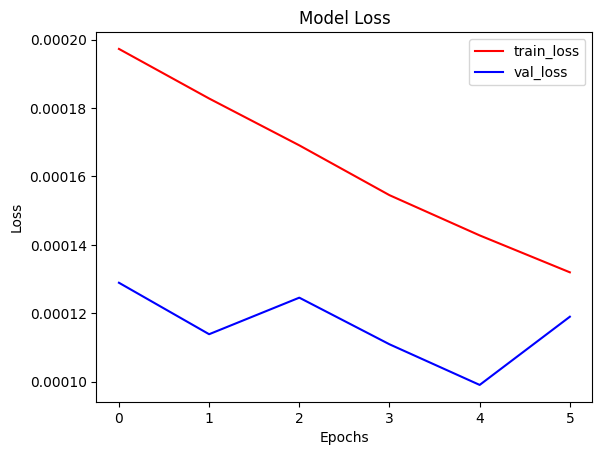

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(train_loss,label='train_loss',color='red')
plt.plot(val_loss,label='val_loss',color='blue')
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [34]:
import joblib

# Save preprocessor after fitting
joblib.dump(preprocessor, "preprocessor.pkl")


['preprocessor.pkl']

In [35]:
# Save
model.save("my_model.keras")


In [36]:
import joblib
joblib.dump(y_scaler,'y_scaler.pkl')

['y_scaler.pkl']

In [33]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt

# y_pred and Y_test_original should be in the ORIGINAL scale (inverse_transformed)
rmse = np.sqrt(mean_squared_error(Y_test_original, y_pred))
mse  = mean_squared_error(Y_test_original, y_pred)
mae  = mean_absolute_error(Y_test_original, y_pred)
mape = mean_absolute_percentage_error(Y_test_original, y_pred)

print(f"R2:  {r2_score(Y_test_original, y_pred):.4f}")
print(f"MSE: {mse:.4e}")
print(f"RMSE:{rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE:{mape:.4%}")


R2:  0.8985
MSE: 1.4834e+09
RMSE:38515.0702
MAE: 15411.5384
MAPE:55949671064497586176.0000%
